# **Notebooks sequence;)**
* Train-val split notebook [*CURRENT ONE*].<br>
* Pretrain roberta-base on mlm with the competition data notebook [here](https://www.kaggle.com/chamecall/clrp-pretrain).<br>
* Finetune pretrained roberta-base on readability task notebook [here](https://www.kaggle.com/chamecall/clrp-finetune).<br>
* Inference model notebook [here](https://www.kaggle.com/chamecall/clrp-inference).<br>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


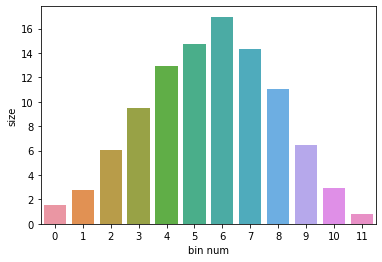

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import KBinsDiscretizer
import transformers
from transformers import AutoModel, BertTokenizerFast
import random
from torch.utils.tensorboard import SummaryWriter
import os 
import seaborn as sns
import matplotlib.pyplot as plt
# specify GPU
device = torch.device("cuda")
seed = 2021
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
def show_hist(df):
    hist_df = df.bins.value_counts()*100/df.shape[0]
    hist_df = hist_df.sort_index()
    ax = sns.barplot(list(map(str,hist_df.index)),hist_df.values) 
    ax.set_xlabel("bin num")
    ax.set_ylabel("size")
    plt.show()
    
seed_everything(seed=seed)

train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
## https://onlinestatbook.com/glossary/sturgiss_rule.html
num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'], bins=num_bins,labels=False)
bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()
# print(train_data.bins.value_counts())
show_hist(train_data)


In [2]:

# train_data['val'] = 0
# kfold = StratifiedShuffleSplit(n_splits=1, random_state=seed, test_size=0.2)
# for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data, y=bins)):
#     train_data.loc[valid_idx,'val'] = 1
    
#     train_df = train_data.loc[train_idx]
#     val_df = train_data.loc[valid_idx]
    
# print(train_df.shape, val_df.shape)
# # print(len(set(train_df.id) | set(val_df.id)), len(train_data))


# ##
# # np.vstack([train_data[train_data.val==0].bins.value_counts(), train_data[train_data.val==1].bins.value_counts()]).T

# train_df.to_csv('train.csv', index=False)
# val_df.to_csv('val.csv', index=False)
# !ls



In [3]:
# train_df.target.plot.kde(label='train')
# val_df.target.plot.kde(label='val')
# ax = train_data.target.plot.kde(label='all data')
# ax.legend()
# ax.set_title('data distribution')

# show_hist(train_df)
# show_hist(val_df)

## K Folds

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


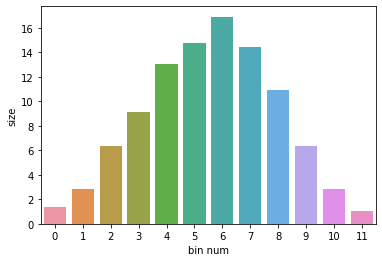

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


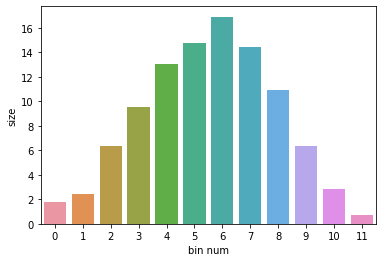

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


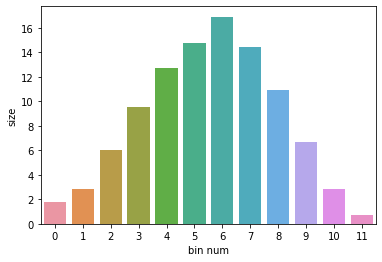

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


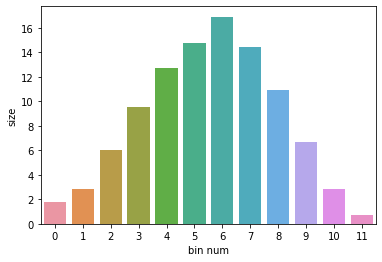

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


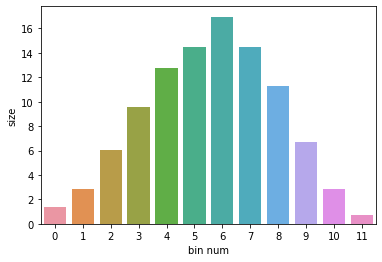

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


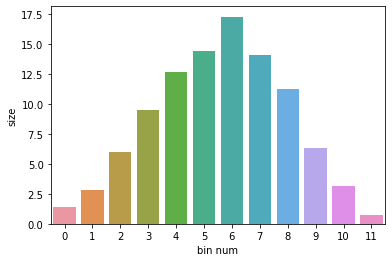

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


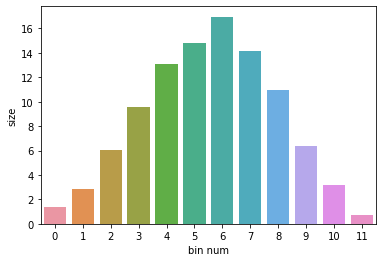

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


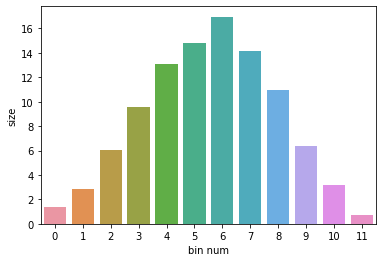

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


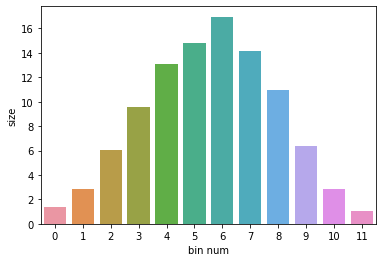

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


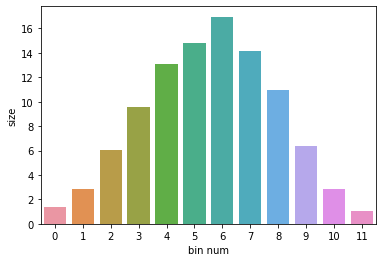

In [4]:
# k folds
train_data['fold'] = 0
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
for fold, (train_idx,valid_idx) in enumerate(kfold.split(X=train_data, y=bins)):
    train_data.loc[valid_idx,'fold'] = fold
    show_hist(train_data.loc[valid_idx])
train_data.fold.value_counts()

train_data.to_csv('kfold.csv', index=False)


In [5]:
!date '+%A %W %Y %X' > execution_time